## Scientific validation of memento implementations

This notebook runs through test cases for differential expression where the p-value outputs
of vanilla memento implementation are compared to the p-value outputs of precomputed memento
implementation

**NOTE**:
- Run this notebook from the `cellxgene-census` repo in the `psridharan/memento-sci-val-1` branch
- Download estimator cube from `s3://psridharan-tmp/memento/memento-cube-census-data-2023-12-15/`

In [16]:
import matplotlib.pyplot as plt
import memento
import numpy as np
import pandas as pd

import cellxgene_census
import cellxgene_census.experimental.diffexp.memento.diff_expr as precomputed_memento

census = cellxgene_census.open_soma(census_version="2023-12-15")
precomputed_memento_estimator_cube_path = (
    "/Users/psridharan/code/cellxgene-census/memento-cubes/memento-cube-census-data-2023-12-15"
)

## TEST CASE 1: Single Dataset, Donor Batch Effects
- treatment variable: `cell_type_ontology_term_id`
- covariates: `donor_id`

In [19]:
# data
dataset_aruna = "59b69042-47c2-47fd-ad03-d21beb99818f"
disease_info_map = {"normal": "PATO:0000461"}

cell_type_monocyte = "classical monocyte"
cell_type_t_cell = "central memory CD4-positive, alpha-beta T cell"
cell_type_info_map = {cell_type_monocyte: "CL:0000860", cell_type_t_cell: "CL:0000904"}


# query params
datasets = [dataset_aruna]

diseases = list(disease_info_map.keys())
disease_ontology_ids = list(disease_info_map.values())

cell_types = list(cell_type_info_map.keys())
cell_type_ontology_ids = list(cell_type_info_map.values())

# a test case is encapsulated as a census query and as a query to precomputed memento cube.
# The precomputed memento cube is the same as the census query except that the precomputed memento cube
# stores ontology term IDs and such the query should be formulated with ontology term IDs
test_case = {
    "census_obs_query": f"is_primary_data == True and dataset_id in {datasets} and disease in {diseases} and cell_type in {cell_types}",
    "precomputed_memento_query": f"dataset_id in {datasets} and disease_ontology_term_id in {disease_ontology_ids} and cell_type_ontology_term_id in {cell_type_ontology_ids}",
}

test_case

{'census_obs_query': "is_primary_data == True and dataset_id in ['59b69042-47c2-47fd-ad03-d21beb99818f'] and disease in ['normal'] and cell_type in ['classical monocyte', 'central memory CD4-positive, alpha-beta T cell']",
 'precomputed_memento_query': "dataset_id in ['59b69042-47c2-47fd-ad03-d21beb99818f'] and disease_ontology_term_id in ['PATO:0000461'] and cell_type_ontology_term_id in ['CL:0000860', 'CL:0000904']"}

#### Get anndata object for test case

In [20]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="homo_sapiens",
    obsm_layers=["scvi"],
    obs_value_filter=test_case["census_obs_query"],
)

adata.obs[["cell_type", "dataset_id"]].value_counts()

cell_type                                       dataset_id                          
classical monocyte                              59b69042-47c2-47fd-ad03-d21beb99818f    4564
central memory CD4-positive, alpha-beta T cell  59b69042-47c2-47fd-ad03-d21beb99818f    2812
Name: count, dtype: int64

#### Run vanilla memento on test case

In [21]:
# Assuming sequenced to 50%, dataset specific number
adata.var.index = adata.var["feature_id"].values  # use feature_id to refer to the gene
adata.obs["q"] = 0.15


# Set treatment variable. Classical monocyte encoded as 1
adata.obs["treatment"] = (adata.obs["cell_type"] == "classical monocyte").astype(int)

# Setup memento
memento.setup_memento(adata, q_column="q", trim_percent=0.1)  # trim_percent tunes cell size calculation

memento.create_groups(adata, label_columns=["treatment", "donor_id"])

memento.compute_1d_moments(adata, min_perc_group=0.9)

group_metadata = memento.get_groups(adata)

treatment_df = group_metadata[["treatment"]]
covariate_df = pd.get_dummies(group_metadata[["donor_id"]], drop_first=True).astype(float)
covariate_df -= covariate_df.mean()  # covariates for Lin's estimator

# Include interactions
covariate_df["interaction"] = treatment_df.iloc[:, 0] * covariate_df.iloc[:, 0]

/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/memento/main.py:181: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [22]:
treatment_df

,treatment
sg^0^cov07,0
sg^1^cov07,1
sg^0^cov08,0
sg^1^cov08,1
sg^0^cov09,0
sg^1^cov09,1
sg^1^cov17,1
sg^0^cov17,0
sg^0^cov18,0
sg^1^cov18,1


In [23]:
covariate_df

,donor_id_cov08,donor_id_cov09,donor_id_cov17,donor_id_cov18,interaction
sg^0^cov07,-0.2,-0.2,-0.2,-0.2,-0.0
sg^1^cov07,-0.2,-0.2,-0.2,-0.2,-0.2
sg^0^cov08,0.8,-0.2,-0.2,-0.2,0.0
sg^1^cov08,0.8,-0.2,-0.2,-0.2,0.8
sg^0^cov09,-0.2,0.8,-0.2,-0.2,-0.0
sg^1^cov09,-0.2,0.8,-0.2,-0.2,-0.2
sg^1^cov17,-0.2,-0.2,0.8,-0.2,-0.2
sg^0^cov17,-0.2,-0.2,0.8,-0.2,-0.0
sg^0^cov18,-0.2,-0.2,-0.2,0.8,-0.0
sg^1^cov18,-0.2,-0.2,-0.2,0.8,-0.2


In [24]:
# Run vanilla memento

memento.ht_1d_moments(
    adata,
    covariate=covariate_df,
    treatment=treatment_df,
    num_boot=5000,
    verbose=1,
    num_cpus=12,
    resample_rep=False,
    approx=False,
)

vanilla_memento_result_df = memento.get_1d_ht_result(adata)

# Sort the result dataframe by gene ensemble name
vanilla_memento_result_df = vanilla_memento_result_df.sort_values("gene")
vanilla_memento_result_df.head(5)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/tiledb/ctx.py:560: UserWarning: TileDB is a multithreading library and deadlocks are likely if fork() is called after a TileDB context has been created (such as for array access). To safely use TileDB with multiprocessing or concurrent.futures, choose 'spawn' as the start method for child processes. For example: multiprocessing.set_start_method('spawn').
  warnings.warn(
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    8.0s
/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:   15.

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
937,ENSG00000000419,treatment,0.364687,0.072641,0.000086,-0.078413,0.299268,0.792242
1668,ENSG00000001497,treatment,0.039923,0.077712,0.607279,0.199968,0.302095,0.498100
104,ENSG00000001629,treatment,0.566675,0.073385,0.000075,-0.052604,0.231213,0.819436
1650,ENSG00000001631,treatment,0.174073,0.070125,0.013597,-0.138273,0.276711,0.593681
1662,ENSG00000002549,treatment,2.020447,0.051671,0.000064,1.234160,0.233148,0.001589


#### Run precomputed memento on test case

In [35]:
# Setup
treatment_dim = "cell_type_ontology_term_id"
covariate_dims = "donor_id"  # supply these as comma separated strings or set to None for no covariates

# Run precomputed memento
precomputed_memento_result_df, _ = precomputed_memento.compute_all(
    cube_path=precomputed_memento_estimator_cube_path,
    query_filter=test_case["precomputed_memento_query"],
    treatment=treatment_dim,
    covariates_str=covariate_dims,
    n_processes=8,
)

# Sort the result dataframe by gene ensemble name
precomputed_memento_result_df = precomputed_memento_result_df.sort_values("feature_id")
precomputed_memento_result_df.head(5)

,coef,z,pval
feature_id,,,
"(ENSG00000000003,)",1.891206,15.524457,2.370035e-54
"(ENSG00000000419,)",-0.550701,-9.138716,6.319813e-20
"(ENSG00000000457,)",-0.029194,-0.281349,7.784424e-01
"(ENSG00000000460,)",-0.235270,-1.346930,1.780027e-01
"(ENSG00000000938,)",-4.475637,-40.313418,0.000000e+00


#### Compare vanilla memento result to precomputed memento result

In [36]:
# construct a set of all the genes in the vanilla memento result dataframe to serve as a structure to
# filter the precomputed memento result dataframe
vanilla_memento_gene_set = set(vanilla_memento_result_df.gene)

# transform vanilla_memento_gene_set into a set of single tuples to match
# the data type of precomputed memento result dataframe index
filter_feature_ids = {(v,) for v in vanilla_memento_gene_set}

# filter the precomputed memento result df to only include genes in the vanilla memento result dataframe
filtered_precomputed_memento_result_df = precomputed_memento_result_df[
    precomputed_memento_result_df.index.isin(filter_feature_ids)
]

print(f"vanilla memento result dataframe length: {len(vanilla_memento_result_df)}")
print(f"precomputed memento result dataframe length: {len(precomputed_memento_result_df)}")
print(f"filtered precomputed memento result dataframe length: {len(filtered_precomputed_memento_result_df)}")

filtered_precomputed_memento_result_df.head(5)

vanilla memento result dataframe length: 4292
precomputed memento result dataframe length: 20693
filtered precomputed memento result dataframe length: 4292


,coef,z,pval
feature_id,,,
"(ENSG00000000419,)",-0.550701,-9.138716,6.319813e-20
"(ENSG00000001497,)",-0.266663,-4.249166,2.145684e-05
"(ENSG00000001629,)",-0.769980,-12.426287,1.881732e-35
"(ENSG00000001631,)",-0.377861,-6.240487,4.362094e-10
"(ENSG00000002549,)",-2.272766,-50.409757,0.000000e+00


##### Plot the p-values for vanilla memento and precomputed memento

/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


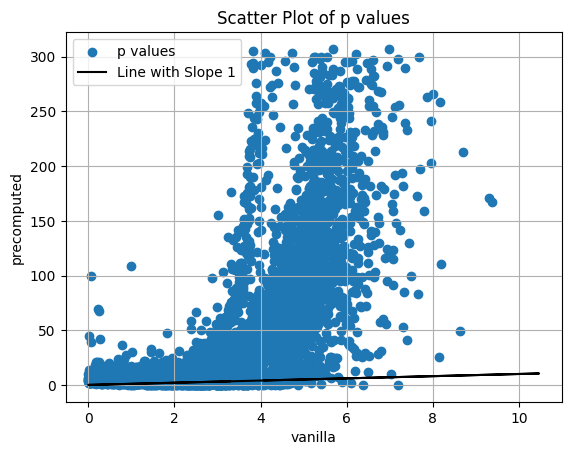

In [37]:
x = -1 * np.log10(vanilla_memento_result_df["de_pval"])
y = -1 * np.log10(filtered_precomputed_memento_result_df["pval"])

plt.scatter(x, y, label="p values")

plt.plot(x, x, color="black", label="Line with Slope 1")

plt.xlabel("vanilla")
plt.ylabel("precomputed")

plt.title("Scatter Plot of p values")
plt.legend()

plt.grid(True)
plt.show()